In [1]:
%pip install mysql-connector-python


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
from sqlalchemy import create_engine
import pandas as pd

# Define your database connection parameters
host="localhost"
port=3306
user="root"
password="Afu27959"
database="thesisCurrent"
database2="thesisv6.9"

# Create a SQLAlchemy engine
engine1 = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

engine2 = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database2}')

# Query to get data
query1 = """
SELECT uniprot, tdl FROM protein JOIN target ON protein.ID = target.ID;
"""
df1 = pd.read_sql(query1, engine1) #Current
#print(df1)

query2 = """
SELECT uniprot, tdl FROM protein JOIN target ON protein.ID = target.ID;
"""
df2 = pd.read_sql(query2, engine2) #Older

def compare_versions(df1, df2):
    # Merge dataframes on 'uniprot'
    merged = df1.rename(columns={'tdl': 'TDL_current'}).merge(
        df2.rename(columns={'tdl': 'TDL_v6_9'}),
        on='uniprot',
        how='outer'
    )
    
    # Find proteins that were Tdark in v6.9 and reclassified in v6.11
    reclassified = merged[(merged['TDL_v6_9'] == 'Tdark') & (merged['TDL_current'] != 'Tdark')]
    
    return reclassified

# Compare versions
reclassified_proteins = compare_versions(df1, df2)

# Display results
#print(reclassified_proteins)
#print(f"Number of reclassified proteins: {len(reclassified_proteins)}")
uniprot_list = reclassified_proteins['uniprot'].tolist()

# Format the list for the SQL query
formatted_uniprot_list = "', '".join(uniprot_list)
print(len(uniprot_list))

# Query to get family information from idg_evol table
query_fam = f"""
SELECT DISTINCT uniprot, fam
FROM idg_evol
WHERE uniprot IN ('{formatted_uniprot_list}');
"""

# Fetch the family data from the database
fam_df = pd.read_sql(query_fam, engine1)

# Merge the family data with the reclassified proteins dataframe
reclassified_proteins_with_fam = reclassified_proteins.merge(fam_df, on='uniprot', how='left')

# Display results with the added family column
print(reclassified_proteins_with_fam)
print(f"Number of reclassified proteins: {len(reclassified_proteins_with_fam)}")


1785
     uniprot TDL_current TDL_v6_9  fam
0     A0AV96        Tbio    Tdark  NaN
1     A0AVF1        Tbio    Tdark  NaN
2     A0FGR9        Tbio    Tdark  NaN
3     A0JNW5        Tbio    Tdark  NaN
4     A0PJK1        Tbio    Tdark  NaN
...      ...         ...      ...  ...
1780  Q9Y6I8        Tbio    Tdark  NaN
1781  Q9Y6I9        Tbio    Tdark  NaN
1782  Q9Y6L7       Tchem    Tdark  NaN
1783  Q9Y6Q3        Tbio    Tdark  NaN
1784  Q9Y6V7        Tbio    Tdark  NaN

[1785 rows x 4 columns]
Number of reclassified proteins: 1785


In [12]:
from sqlalchemy import create_engine
import pandas as pd

print(uniprot_list)
print(len(uniprot_list))

# Ensure there are proteins to query
if uniprot_list:
    # Format the list for the SQL query
    formatted_uniprot_list = "', '".join(uniprot_list)
    print(len(formatted_uniprot_list))
    
    # Query to get SMILES, sequences, and affinities
    query_data = f"""
    SELECT 
        p.uniprot AS uniprot,
        p.name AS protein_name,
        p.seq AS sequence,
        p.description AS protein_description,
        dcid AS smiles_id,
        da.smiles AS smiles,
        da.act_value AS affinity,
        'drug_activity' AS source_table
    FROM 
        protein p
    JOIN 
        drug_activity da ON p.id = da.target_id
    WHERE 
        p.uniprot IN ('{formatted_uniprot_list}')
    UNION ALL

    SELECT 
        p.uniprot AS uniprot,
        p.name AS protein_name,
        p.seq AS sequence,
        p.description AS protein_description,
        cmpd_id_in_src AS smiles_id,
        ca.smiles AS smiles,
        ca.act_value AS affinity,
        'cmpd_activity' AS source_table
    FROM 
        protein p
    JOIN 
        target t ON p.id = t.id
    JOIN 
        cmpd_activity ca ON t.id = ca.target_id
    WHERE 
        p.uniprot IN ('{formatted_uniprot_list}')
    """
    
    # Fetch the data from the database
    data_df = pd.read_sql(query_data, engine1)
    
    # Display results
    print(data_df)
    print(f"Number of entries collected: {len(data_df)}")
else:
    print("No reclassified proteins found to query.")


['A0AV96', 'A0AVF1', 'A0FGR9', 'A0JNW5', 'A0PJK1', 'A0PJX4', 'A1A4T8', 'A1A5C7', 'A1KZ92', 'A1L020', 'A1L188', 'A1L390', 'A1L4H1', 'A1L4K1', 'A1YPR0', 'A2RUB6', 'A2RUH7', 'A2VCL2', 'A2VDF0', 'A4D0S4', 'A4D1E9', 'A4D1P6', 'A4D1S5', 'A4D2P6', 'A5D8W1', 'A5PLK6', 'A6NC51', 'A6NC98', 'A6NCD4', 'A6NCL1', 'A6ND91', 'A6NDY0', 'A6NED2', 'A6NEK1', 'A6NFX1', 'A6NHN0', 'A6NJ16', 'A6NJS3', 'A6NK58', 'A6NKB5', 'A6NKD9', 'A6NKG5', 'A6NL88', 'A6NLJ0', 'A6NM15', 'A6NND4', 'A6NNW6', 'A6NNY8', 'A6ZKI3', 'A7MBM2', 'A7XYQ1', 'A8MPS7', 'A8MT82', 'A8MTJ6', 'A8MW92', 'A8MWS1', 'A8MYP8', 'A9QM74', 'B1AKI9', 'B2RTY4', 'B3EWG4', 'B7U540', 'B7ZAP0', 'B7ZBB8', 'C9JE40', 'C9JR72', 'C9JVW0', 'I3L1I5', 'O00124', 'O00160', 'O00295', 'O00478', 'O00488', 'O00634', 'O14523', 'O14529', 'O14545', 'O14610', 'O14626', 'O14645', 'O14668', 'O14669', 'O14771', 'O14817', 'O14841', 'O14957', 'O14978', 'O15016', 'O15033', 'O15040', 'O15042', 'O15090', 'O15126', 'O15213', 'O15231', 'O15254', 'O15342', 'O15453', 'O15514', 'O43257',

In [13]:
print(data_df.columns)


Index(['uniprot', 'protein_name', 'sequence', 'protein_description',
       'smiles_id', 'smiles', 'affinity', 'source_table'],
      dtype='object')


***Creating pharos.csv***

In [14]:
# Rename columns
query_output = data_df.rename(columns={
    'smiles': 'compound_iso_smiles',
    'sequence': 'target_sequence',
    'affinity': 'affinity'
})
# Check for empty strings in the specified columns
empty_strings = (query_output[['compound_iso_smiles', 'target_sequence', 'affinity']] == "").sum()
print("Empty strings in each column:\n", empty_strings)

# Replace empty strings with NaN
query_output.replace("", float("nan"), inplace=True)

# Check for missing values in the specified columns
missing_values = query_output[['compound_iso_smiles', 'target_sequence', 'affinity']].isnull().sum()
print("Missing values in each column:\n", missing_values)


# Select only the specified columns and drop rows with any missing values in these columns
filtered_output = query_output[['compound_iso_smiles', 'target_sequence', 'affinity']].dropna()

# Save to CSV
filtered_output.to_csv('pharos.csv', index=False)
print(data_df.columns)


Empty strings in each column:
 compound_iso_smiles    3
target_sequence        0
affinity               0
dtype: int64
Missing values in each column:
 compound_iso_smiles    3
target_sequence        0
affinity               0
dtype: int64
Index(['uniprot', 'protein_name', 'sequence', 'protein_description',
       'smiles_id', 'smiles', 'affinity', 'source_table'],
      dtype='object')


In [15]:
print(filtered_output.columns)

Index(['compound_iso_smiles', 'target_sequence', 'affinity'], dtype='object')


***Create train test validation  split***

In [16]:
import pandas as pd
import numpy as np
import random
import os

# Set a random seed for reproducibility
random.seed(42)

# Step 1: Load the complete dataset
pharos_data = pd.read_csv('pharos.csv')

# Step 2: Save the original dataset
original_data_path = 'data/pharos_original.csv'
pharos_data.to_csv(original_data_path, index=False)
print(f'Original dataset saved at {original_data_path}.')

# Step 3: Blinding the interactions
# Choose a percentage of interactions to blind (e.g., 20%)
blind_percentage = 0.2
num_to_blind = int(len(pharos_data) * blind_percentage)

# Randomly select indices to blind
indices_to_blind = random.sample(range(len(pharos_data)), num_to_blind)

# Create a new DataFrame for the blinded dataset
blinded_data = pharos_data.copy()

# Set the affinity values for the selected indices to NaN
blinded_data.loc[indices_to_blind, 'affinity'] = np.nan

# Step 4: Save the blinded dataset
blinded_data_path = 'data/pharos_blinded.csv'
blinded_data.to_csv(blinded_data_path, index=False)
print(f'Blinded dataset created with {num_to_blind} interactions blinded.')

# Step 5: Prepare the validation and training datasets
# Extract the blinded interactions for validation
validation_data = blinded_data[blinded_data['affinity'].isna()]

# Save the validation data
validation_data_path = 'data/pharos_validation.csv'
validation_data.to_csv(validation_data_path, index=False)
print(f'Validation dataset saved at {validation_data_path}.')

# Prepare the non-blinded data for training/testing
non_blinded_data = blinded_data[blinded_data['affinity'].notna()]

# Save the non-blinded data for processing by create_data.py
non_blinded_data_path = 'data/pharos.csv' 
non_blinded_data.to_csv(non_blinded_data_path, index=False)
print(f'Non-blinded dataset saved at {non_blinded_data_path} for processing.')


Original dataset saved at data/pharos_original.csv.
Blinded dataset created with 99 interactions blinded.
Validation dataset saved at data/pharos_validation.csv.
Non-blinded dataset saved at data/pharos.csv for processing.


In [17]:
import pandas as pd
import numpy as np
import json
import pickle
import os

# Load the pharos.csv file into a DataFrame
pharos_df = pd.read_csv('pharos.csv')

# Assuming you still have the original data_df from the SQL query
# Create a set of SMILES to filter by
smiles_set = set(pharos_df['compound_iso_smiles'])

# Create dictionaries to store data
ligands = {}
proteins = {}
y_affinities = {}

for _, row in data_df.iterrows():
    smiles = row['smiles']
    smiles_id = row['smiles_id']
    uniprot = row['uniprot']
    affinity = row['affinity']
    
    if smiles in smiles_set:
        ligands[smiles_id] = smiles
        y_affinities[(smiles_id, uniprot)] = affinity
        if uniprot not in proteins:
            proteins[uniprot] = row['sequence']

# Create a list of unique smiles_ids and uniprots to form the grid
smiles_ids = sorted(ligands.keys())
uniprots = sorted(proteins.keys())

# Initialize a 2D NumPy array with a default value of 5.0
affinity_matrix = np.full((len(smiles_ids), len(uniprots)), 5.0)

# Populate the matrix with available affinity values
for (smiles_id, uniprot), affinity in y_affinities.items():
    i = smiles_ids.index(smiles_id)
    j = uniprots.index(uniprot)
    affinity_matrix[i, j] = affinity

# Define the directory to save the text files
output_dir = 'data/pharos'
os.makedirs(output_dir, exist_ok=True)

# Save ligands, proteins, and Y data
with open(os.path.join(output_dir, 'ligands_can.txt'), 'w') as f:
    json.dump(ligands, f, indent=4)

with open(os.path.join(output_dir, 'proteins.txt'), 'w') as f:
    json.dump(proteins, f, indent=4)

with open(os.path.join(output_dir, 'Y'), 'wb') as f:
    pickle.dump(affinity_matrix, f)

print("Ligands, Proteins, and Y files created successfully.")


Ligands, Proteins, and Y files created successfully.


***fold index files***

In [18]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import KFold

# Load the non-blinded dataset
non_blinded_data_path = 'data/pharos.csv'
non_blinded_data = pd.read_csv(non_blinded_data_path)

# Assign a unique index to each data point
data_indices = list(range(len(non_blinded_data)))

# Define the number of folds (usually 5 for cross-validation)
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Create train/test splits
train_folds = []
test_folds = []

for train_idx, test_idx in kf.split(data_indices):
    train_folds.append(train_idx.tolist())
    test_folds.append(test_idx.tolist())

# Save train fold file
with open('data/pharos/folds/train_fold_setting1.txt', 'w') as f:
    json.dump(train_folds, f)

# Save only the first test fold in the specified format
first_test_fold = test_folds[0]
with open('data/pharos/folds/test_fold_setting1.txt', 'w') as f:
    f.write(f"{first_test_fold}")

print("Train and test fold files saved successfully.")


Train and test fold files saved successfully.


Trying to run create_data to get pt files

In [13]:
!pip install numpy<2

!python create_data.py

zsh:1: no such file or directory: 2

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/adele/Documents/GitHub/GraphDTA/create_data.py", line 6, in <module>
    from rdkit import Chem
  File "/Users/adele/Documents/GitHub/GraphDTA/.venv/lib/python3.11/site-packages/rdkit/Chem/__init__.py", line 18, in <module>
    from rdkit import DataStructs
  File "/Users/adele/Documents/GitHub/GraphDTA/.venv/lib/python3.11/site-packages/rdkit/DataStructs/__init__.py", line 13, in <module>
    from rdkit.DataStructs import cDataStructs
AttributeError: _ARRAY_API not found


In [19]:
import os
import pandas as pd
import torch
import numpy as np
from create_data import smile_to_graph
from utils import TestbedDataset

seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:(i+1) for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000
def seq_cat(prot):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  

compound_iso_smiles = []
df = pd.read_csv('data/pharos_validation.csv')
compound_iso_smiles += list( df['compound_iso_smiles'] )
compound_iso_smiles = set(compound_iso_smiles)
smile_graph = {}
for smile in compound_iso_smiles:
    g = smile_to_graph(smile)
    smile_graph[smile] = g

# Define the path for the validation data
validation_file = 'data/pharos_validation.csv'
processed_validation_file = 'data/processed/pharos_validation.pt'

# Check if the processed validation file already exists
if not os.path.isfile(processed_validation_file):
    # Load the validation dataset
    validation_df = pd.read_csv(validation_file)
    validation_drugs = validation_df['compound_iso_smiles'].values
    validation_prots = validation_df['target_sequence'].values
    validation_Y = validation_df['affinity'].values
    
    # Convert protein sequences using seq_cat (assuming this function exists)
    validation_encoded_prots = [seq_cat(t) for t in validation_prots]

    # Make the data ready for PyTorch Geometric
    print('Preparing validation_data.pt in PyTorch format!')
    validation_data = TestbedDataset(
        root='data',
        dataset='pharos_validation',
        xd=validation_drugs,
        xt=validation_encoded_prots,
        y=validation_Y,
        smile_graph=smile_graph  # This assumes you've already created `smile_graph`
    )

    # Save the validation dataset
    torch.save(validation_data, processed_validation_file)
    print(f"{processed_validation_file} has been created")
else:
    print(f"{processed_validation_file} already exists")


data/processed/pharos_validation.pt already exists


In [20]:
import torch
from torch_geometric.data import DataLoader
from models.ginconv import GINConvNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation dataset
validation_data = torch.load('data/processed/pharos_validation.pt')

# Create a DataLoader for the validation dataset
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

# Define the model architecture (ensure this matches the one you used for training)
model = GINConvNet()  # or whichever model you used (e.g., GAT_GCN, GCNNet, etc.)

# Load the trained model weights (ensure the correct model path)
model_file_name = 'model_GINConvNet_pharos.model'  # Update with your model file name
model.load_state_dict(torch.load(model_file_name))
model.eval()  # Set the model to evaluation mode

# Define a function to make predictions
def predict_affinities(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            batch_data = batch_data.to(device)  # Move data to the appropriate device
            output = model(batch_data)  # Forward pass to get predictions
            all_outputs.append(output.cpu().numpy())  # Store outputs (convert to numpy if needed)

    return np.concatenate(all_outputs)  # Concatenate outputs into a single array

# Run predictions on the validation data
outputs = predict_affinities(model, validation_loader)

# Print or save the predictions
print("Predictions on validation dataset:", outputs)


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_52970/2709359683.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_data = torch.load('data/processed/

Predictions on validation dataset: [[5.027618 ]
 [4.8876514]
 [5.0232573]
 [4.9473543]
 [4.9129333]
 [4.959687 ]
 [4.959687 ]
 [5.3667192]
 [5.05744  ]
 [4.7354765]
 [4.7826223]
 [5.221624 ]
 [5.035588 ]
 [4.833246 ]
 [5.1185465]
 [4.9054065]
 [5.081519 ]
 [4.951465 ]
 [4.890942 ]
 [4.9466777]
 [4.7899027]
 [4.873542 ]
 [4.873542 ]
 [4.9419928]
 [4.8251114]
 [4.8234057]
 [4.896864 ]
 [4.8251114]
 [4.896864 ]
 [4.9226217]
 [4.9226217]
 [4.7899027]
 [4.9419928]
 [4.9419928]
 [5.0548706]
 [4.9043765]
 [4.9419928]
 [5.0548706]
 [4.9043765]
 [4.9043765]
 [4.9793134]
 [4.9419928]
 [4.7899027]
 [4.7899027]
 [4.7899027]
 [4.9793134]
 [4.822919 ]
 [4.9793134]
 [4.9778833]
 [4.912729 ]
 [5.0548706]
 [4.914769 ]
 [5.278407 ]
 [4.7996583]
 [4.8920174]
 [5.072595 ]
 [5.2120776]
 [4.9244547]
 [4.8566136]
 [4.7192903]
 [4.7641034]
 [4.7050104]
 [4.7761793]
 [4.778245 ]
 [4.725715 ]
 [4.770055 ]
 [4.8193707]
 [5.0403843]
 [4.877531 ]
 [4.8527064]
 [4.8368664]
 [5.278407 ]
 [4.8647757]
 [4.9824324]
 [5

99
99
Mean Absolute Error (MAE): 2.3300813960085107
Mean Squared Error (MSE): 5.8513124587885885
R-squared (R²): -12.645345823447595


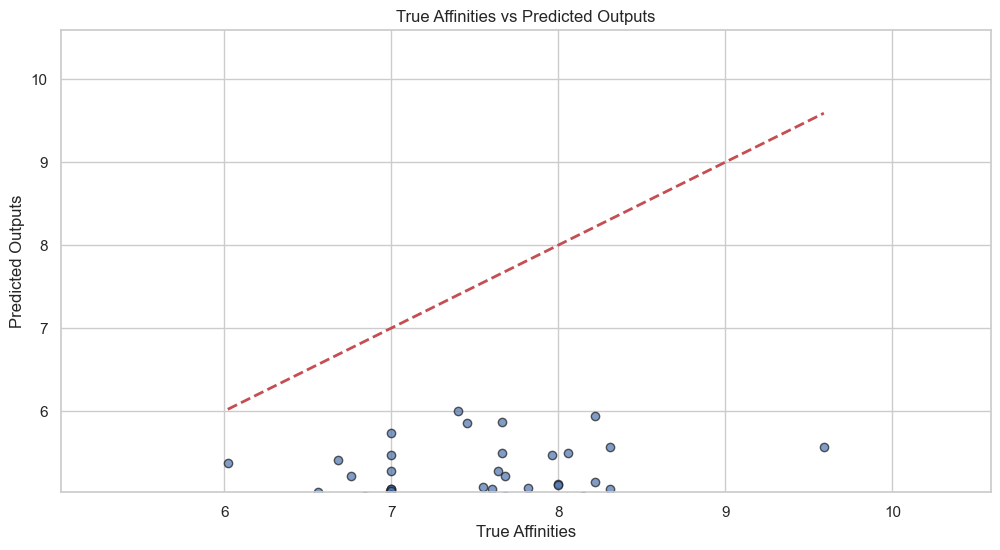

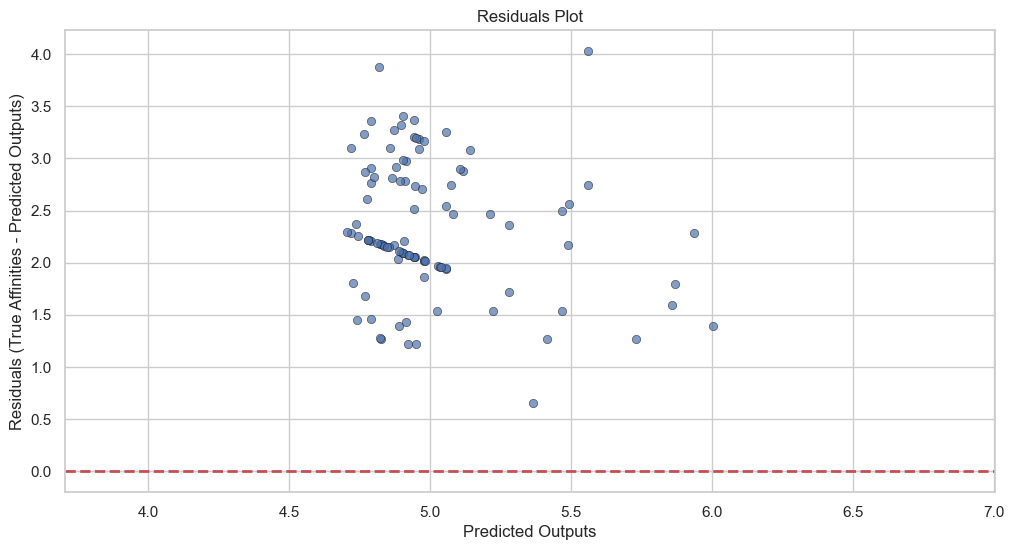

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load the original data to get true affinity values
original_data = pd.read_csv('data/pharos_original.csv')

# Step 2: Load the validation data
validation_data = pd.read_csv('data/pharos_validation.csv')

# Step 3: Extract true affinity values from the original dataset
# Assuming 'indices_to_blind' is defined in your context
true_affinities = original_data.loc[indices_to_blind, 'affinity'].values

print(len(true_affinities))
print(len(outputs))

# 'outputs' is a numpy array of predicted affinity values
# For example:
# outputs = np.array([...])  # Your predicted affinity values

# Step 4: Calculate evaluation metrics
mae = mean_absolute_error(true_affinities, outputs)
mse = mean_squared_error(true_affinities, outputs)
r2 = r2_score(true_affinities, outputs)

# Step 5: Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

# Data Visualization

# Ensure that outputs and true_affinities are 1D arrays
outputs = np.ravel(outputs)  # Flatten outputs if necessary
true_affinities = np.ravel(true_affinities)  # Flatten true affinities if necessary

# Calculate residuals
residuals = true_affinities - outputs

# Set the style of seaborn
sns.set(style='whitegrid')

# Scatter plot: True vs Predicted Affinities
plt.figure(figsize=(12, 6))
plt.scatter(true_affinities, outputs, alpha=0.7, edgecolors='k')
plt.plot([true_affinities.min(), true_affinities.max()], 
         [true_affinities.min(), true_affinities.max()], 
         'r--', lw=2)  # Diagonal line for reference
plt.title('True Affinities vs Predicted Outputs')
plt.xlabel('True Affinities')
plt.ylabel('Predicted Outputs')
plt.xlim(true_affinities.min() - 1, true_affinities.max() + 1)
plt.ylim(true_affinities.min() - 1, true_affinities.max() + 1)
plt.show()

# Residual plot: Errors
plt.figure(figsize=(12, 6))
sns.scatterplot(x=outputs, y=residuals, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)  # Line at zero for reference
plt.title('Residuals Plot')
plt.xlabel('Predicted Outputs')
plt.ylabel('Residuals (True Affinities - Predicted Outputs)')
plt.xlim(outputs.min() - 1, outputs.max() + 1)
plt.show()
